### Introduction


A beverage subscription service company has observed a notable surge in subscription cancellations, recognizing the substantial impact that churn rate has on both the company's revenue and its long-term viability. In response to this challenge, the company is poised to employ machine learning algorithms to forecast and pinpoint customers at risk of cancellation. The objective is to formulate effective strategies aimed at minimizing churn and ensuring the sustainability of the business.

This analysis on churn rate delves into the intricate patterns and indicators that precede customer attrition. Through a comprehensive exploration of historical data encompassing customer interactions, preferences, and transactional behaviors, the intention is to harness the predictive capabilities of machine learning. The goal is to uncover nuanced signals that serve as precursors to potential cancellations.

The overarching objective is to develop predictive models capable of identifying customers exhibiting a higher likelihood of churning. By leveraging this predictive capability, the business aims to implement targeted retention strategies. This proactive approach is designed to reduce churn rates, retain valuable clientele, and optimize overall customer satisfaction, thus fostering a more sustainable and thriving subscription service.

About the data
- customer_id             :object 
- subscription_start_date :object 
- subscription_end_date   :object 
- subscription_status     :object 
- monthly_payment_amount  :float64
- total_payments          :int64  
- cancellation_reason     :object
- last_order_date         :object 
- age                     :int64  
- gender                  :object 
- employment_status       :object 
- total_subscriptions     :int64  
- payment_method          :object 

Source: Generate via faker

In [167]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import datetime as dt
# pd.set_option('precision', 3)


import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

!pip install seaborn --upgrade
import seaborn as sns
sns.set_style('darkgrid')

# Statistics
from scipy.stats import chi2_contingency
from scipy import stats
# from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import learning_curve

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.decomposition import PCA


from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score,f1_score, auc, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
# import scikitplot as skplt


[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [114]:

data = pd.read_csv('C:\\Users\\DELL\\Downloads\\subscriptions.csv')
data.head()

,customer_id,subscription_start_date,subscription_end_date,subscription_status,cancellation_reason,monthly_payment_amount,total_payments,last_order_date,age,gender,employment_status,total_subscriptions,payment_method
0,61d8161d-fd47-484c-8b14-0c31f40031a7,2/14/2023,12/31/2023,Active,Other,15728.34560,1,4/20/2023,31,Female,Employed,9,Mobile Money
1,6ef4b93b-0ff0-40fd-9ddc-38c3465b27ba,1/29/2023,12/31/2023,Cancelled,Changed service,16729.15228,9,11/3/2023,70,Female,Unemployed,7,Debit Card
2,16d6418b-b3cc-4304-a69a-e909369fbfd4,6/14/2023,1/19/2024,Active,Other,14145.17308,6,6/30/2023,66,Male,Unemployed,10,Mobile Money
3,5a8a077f-5f85-4384-a094-dd8e2b398f65,3/1/2023,12/31/2023,Active,Changed service,8372.18017,1,8/5/2023,29,Male,Employed,7,Mobile Money
4,27b71daa-03e5-49c2-81c3-519f8f993f18,8/16/2023,12/31/2023,Active,Changed service,17884.85924,3,12/14/2023,30,Male,Unemployed,3,Mobile Money


### Exploratory Data Analysis

In [115]:
def check(df):
    print("Shape". center(82,'~'))
    print("Rows:{}".format(df.shape[0]))
    print("Columns:{}".format(df.shape[1]))
    print("Data Type". center(82,'~'))
    print(df.dtypes)
    print("Null Values". center(82,'~'))
    print(df.isnull().sum())
    print("Percentage Null Values". center(82,'~'))
    print((df.isnull().mean()*100).round(2))
    print("Duplicates". center(82,'~'))
    print(df.duplicated().sum())

check(data)



def check_variable(df):
    nunique_df = pd.DataFrame({'Variable':df.columns, 'Classes':[f'{df[i].nunique()} labels' for i in df.columns]})
    nunique_df = nunique_df.sort_values('Classes', ascending = False)
    nunique_df = nunique_df.reset_index(drop =True)
    return nunique_df
check_variable(data[['employment_status','gender','payment_method','subscription_status']])

print("employment_status". center(82,'~'))
print(data['employment_status'].value_counts())
print("gender". center(82,'~'))
print(data['gender'].value_counts())
print("payment_method". center(82,'~'))
print(data['payment_method'].value_counts())
print("subscription_status". center(82,'~'))
print(data['subscription_status'].value_counts())

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Shape~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Rows:6848
Columns:13
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Data Type~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
customer_id                 object
subscription_start_date     object
subscription_end_date       object
subscription_status         object
cancellation_reason         object
monthly_payment_amount     float64
total_payments               int64
last_order_date             object
age                          int64
gender                      object
employment_status           object
total_subscriptions          int64
payment_method              object
dtype: object
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Null Values~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
customer_id                0
subscription_start_date    0
subscription_end_date      0
subscription_status        0
cancellation_reason        0
monthly_payment_amount     0
total_payments             0
last_order_date            0
age                        0


In [116]:
cols = ['monthly_payment_amount','age','total_subscriptions','total_payments']
data[cols].describe().T

,count,mean,std,min,25%,50%,75%,max
monthly_payment_amount,6848.0,11967.916508,4603.259472,4000.345983,7965.006422,12030.94631,15887.422357,19998.6269
age,6848.0,44.062062,15.478411,18.000000,30.000000,44.00000,58.000000,70.0000
total_subscriptions,6848.0,6.538843,3.461142,1.000000,4.000000,7.00000,10.000000,12.0000
total_payments,6848.0,6.422605,3.444631,1.000000,3.000000,6.00000,9.000000,12.0000


#### Visualizing the categorical variables

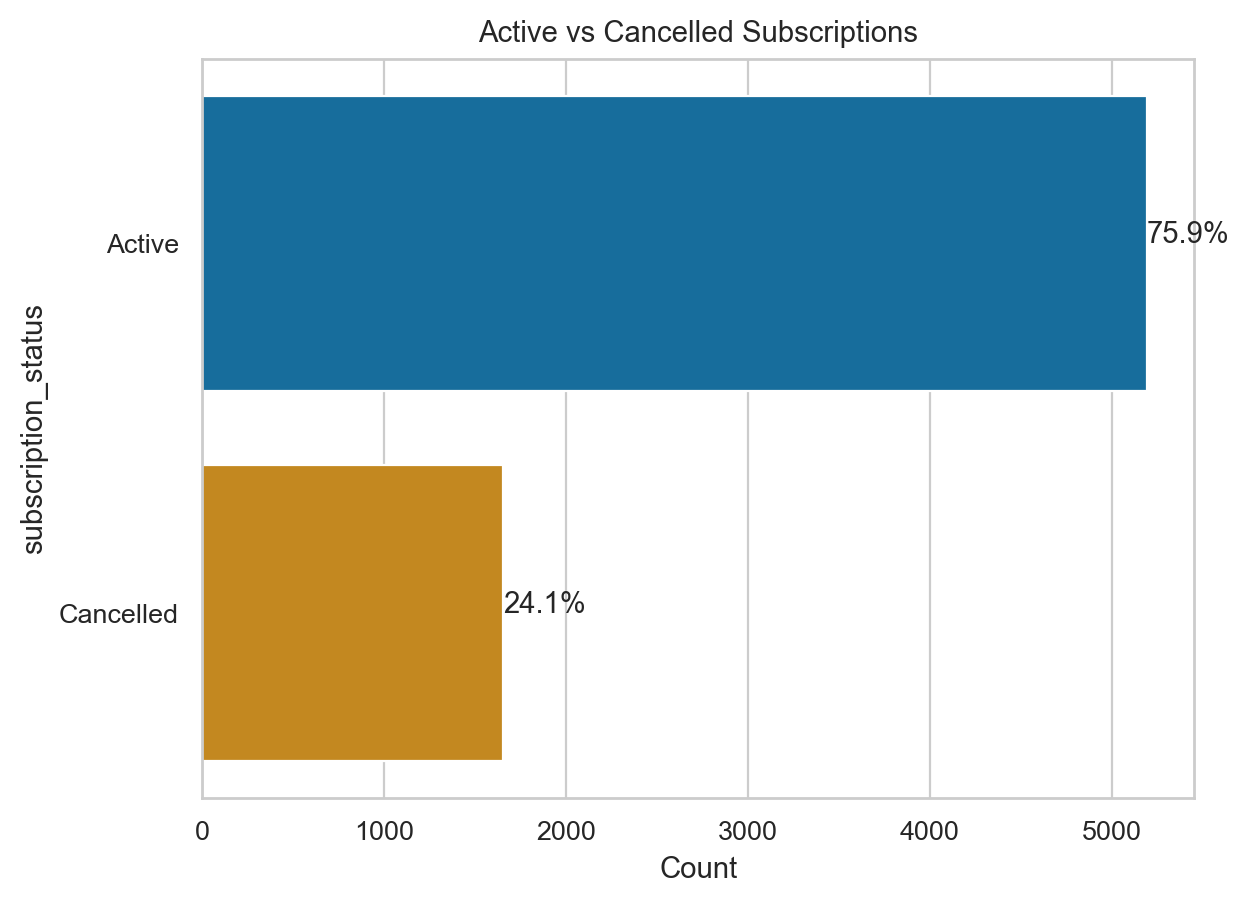

In [117]:
sns.set_style('whitegrid')

# Create the countplot and naming it 'plot'. 
plot = sns.countplot(y='subscription_status', data=data, palette='colorblind')

plt.xlabel('Count')
plt.ylabel('subscription_status')
plt.title('Active vs Cancelled Subscriptions')

total = len(data['subscription_status']) 

for p in plot.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height() / 2
    plot.annotate(percentage, (x, y))
plt.show()

24.1% of the customers cancelled their subscriptions. The historic churn rate is quite high hence we need to get granular view of the cancelled the suscriptions inorder to identify reasons why almost one quarter of the customers cancelled their subscriptions. 

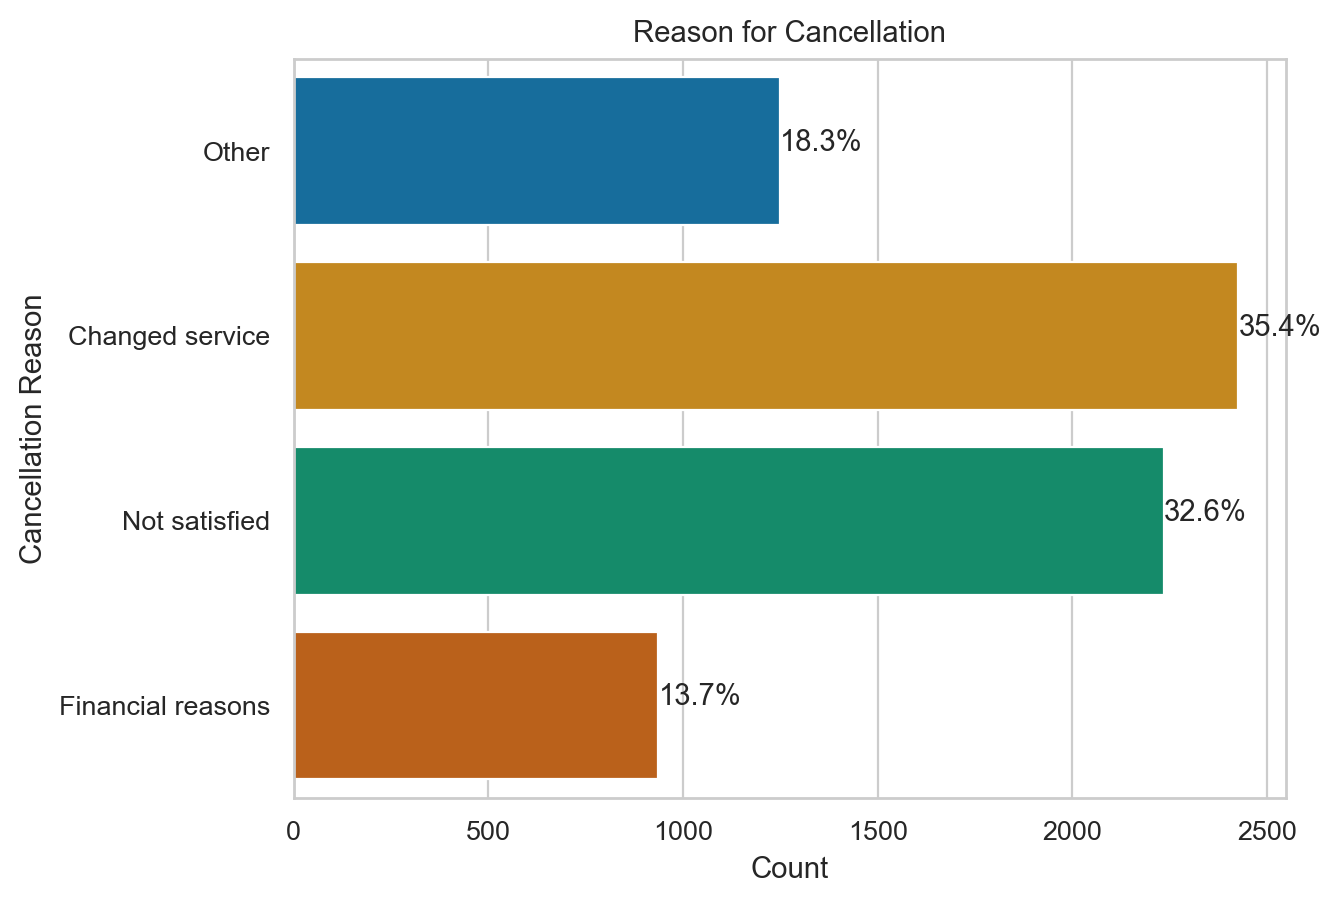

In [118]:
sns.set_style('whitegrid')

# Create the countplot and naming it 'plot'. 
plot = sns.countplot(y='cancellation_reason', data=data, palette='colorblind')

plt.xlabel('Count')
plt.ylabel('Cancellation Reason')
plt.title('Reason for Cancellation')

total = len(data['cancellation_reason']) 

for p in plot.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height() / 2
    plot.annotate(percentage, (x, y))
plt.show()

Majority of the customers were either not satisfied (32.6%) with the service or just wanted a different service (35.4%) provider. This insight indicates that the quality of service rendered needs to be evaluated and compared with what other service providers are offering.

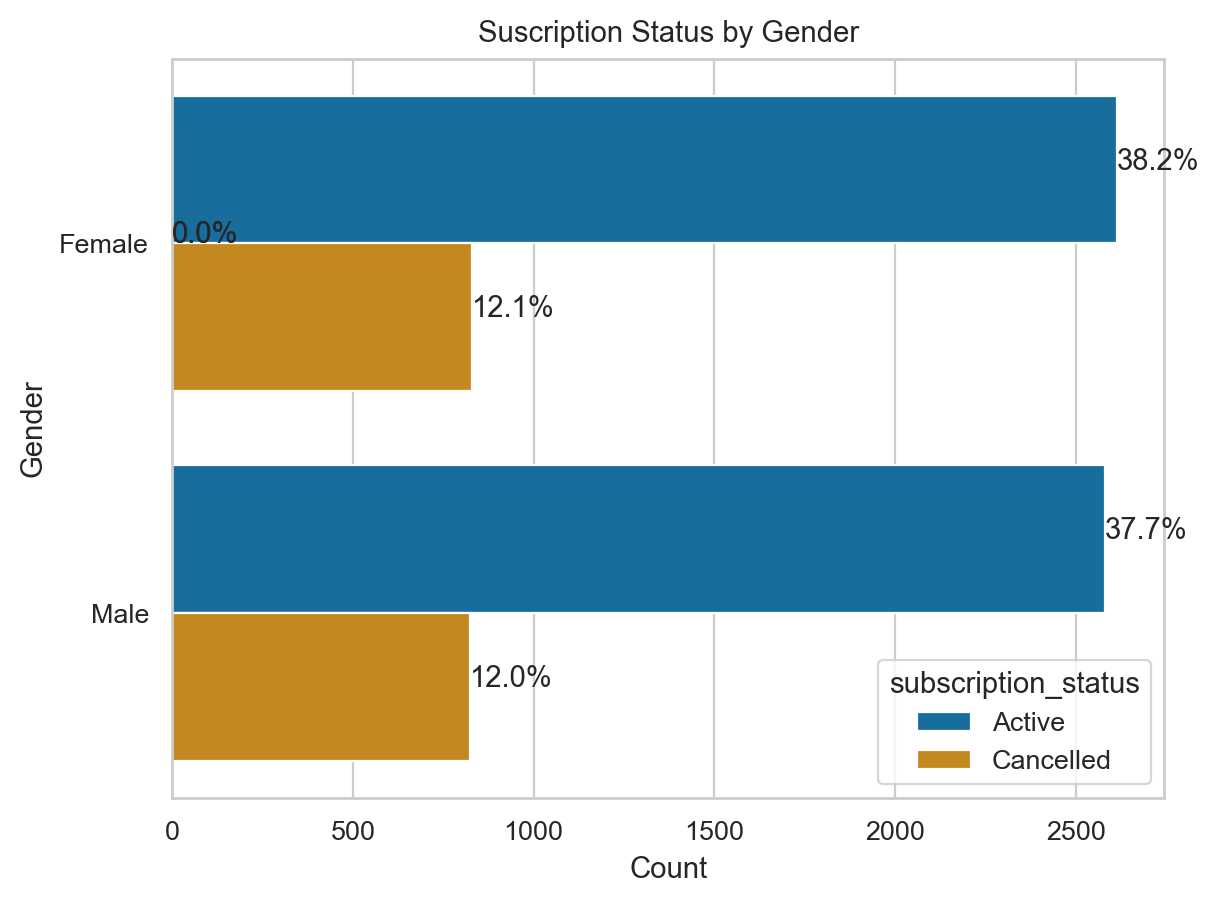

In [119]:
sns.set_style('whitegrid')

plot = sns.countplot(y='gender' , hue='subscription_status', data=data, palette='colorblind')

plt.xlabel('Count')
plt.ylabel('Gender')
plt.title('Suscription Status by Gender')

total = len(data['gender']) 

for p in plot.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height() / 2
    plot.annotate(percentage, (x, y))
plt.show()

The churn rate for female customers is slightly higher than that of female customers.

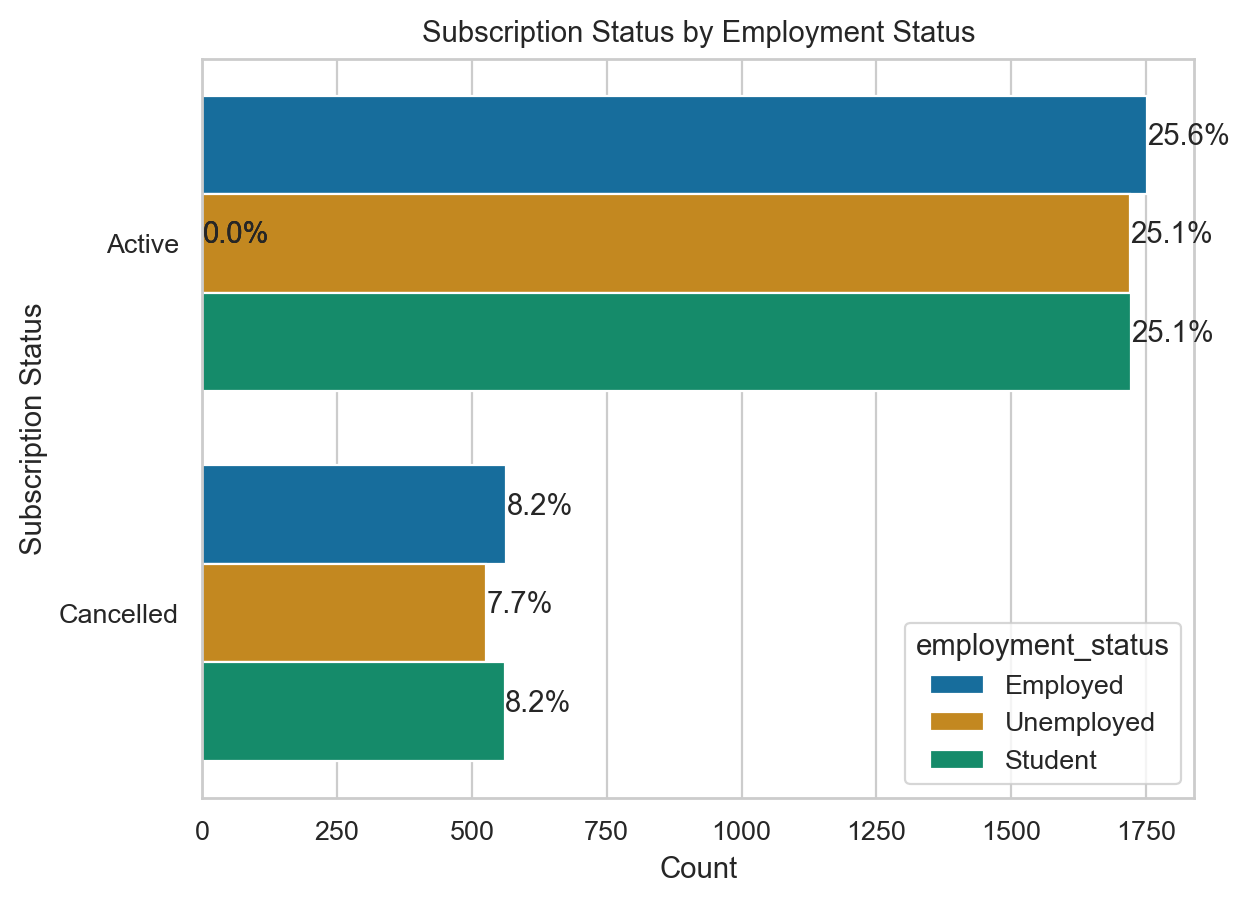

In [120]:
sns.set_style('whitegrid')

plot = sns.countplot(y='subscription_status' ,hue='employment_status', data=data, palette='colorblind')

plt.xlabel('Count')
plt.ylabel('Subscription Status')
plt.title('Subscription Status by Employment Status')

total = len(data['subscription_status']) 

for p in plot.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height() / 2
    plot.annotate(percentage, (x, y))
plt.show()

Employed customers have a higher churn rate compared to unemployed customers and students.

#### Visualizing the numeric variables

In [121]:


def plot_nv(data, feature):
    
    df_func = data.copy()
    df_func['employment_status'] = df_func['employment_status'].astype('category')

    fig, (ax1, ax2) = plt.subplots(2, figsize=(6, 5), sharex=True)

    colors = ['steelblue', 'firebrick','black']
    
    for label, color in zip(['Active', 'Cancelled'], colors):
        sns.histplot(data=df_func[df_func['subscription_status'] == label],
                     x=feature,
                     bins=15,
                     color=color,
                     alpha=0.66,
                     edgecolor='black',
                     label=label,
                     kde=False,
                     ax=ax1)
    ax1.legend()

    sns.boxplot(x=feature, y='subscription_status', data=df_func, palette=colors, ax=ax2)
    ax2.set_ylabel('')
    ax2.set_yticklabels(['Active', 'Cancelled'])

    plt.tight_layout()
    plt.show()


C:\Users\DELL\AppData\Local\Temp\ipykernel_15312\3175758177.py:22: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(x=feature, y='subscription_status', data=df_func, palette=colors, ax=ax2)
C:\Users\DELL\AppData\Local\Temp\ipykernel_15312\3175758177.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['Active', 'Cancelled'])


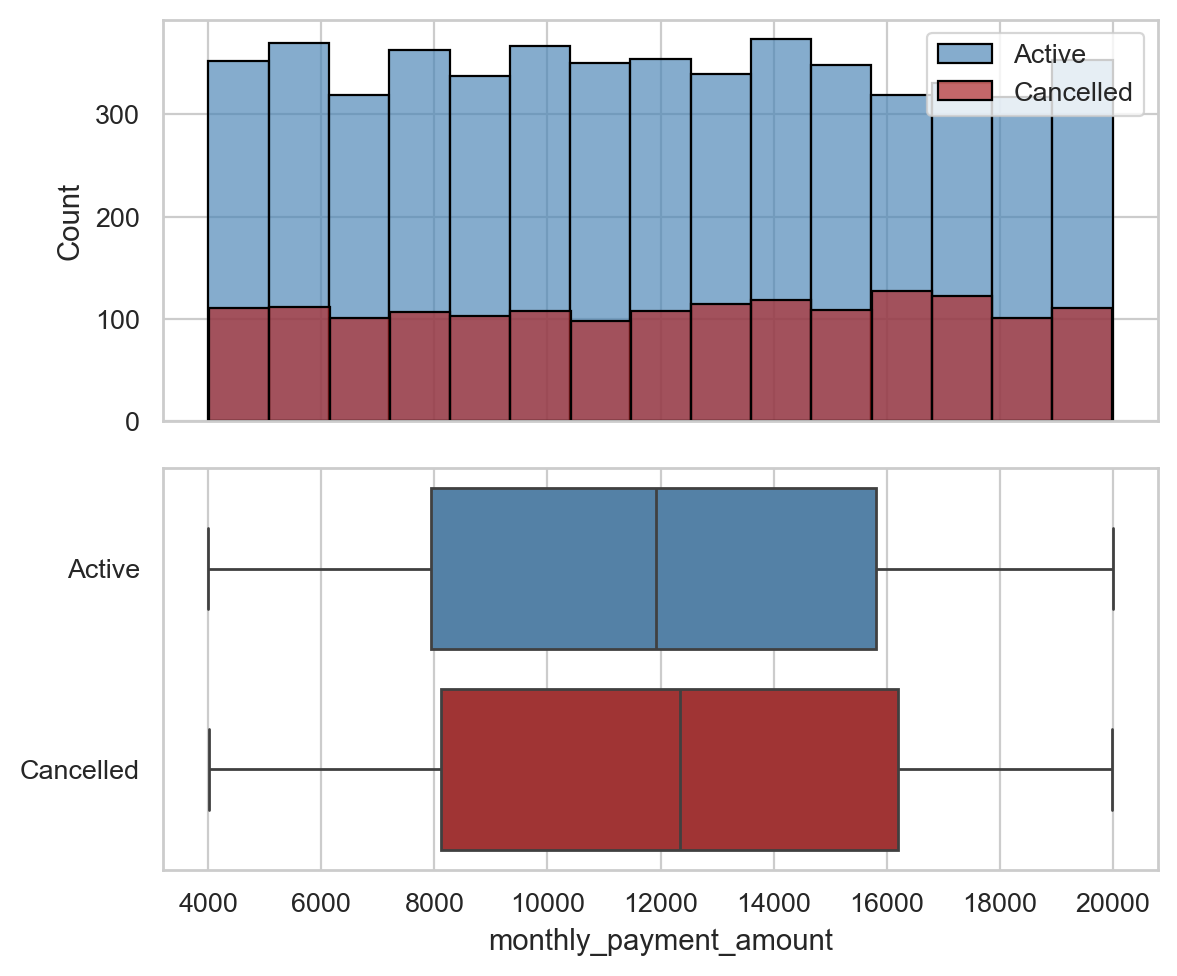

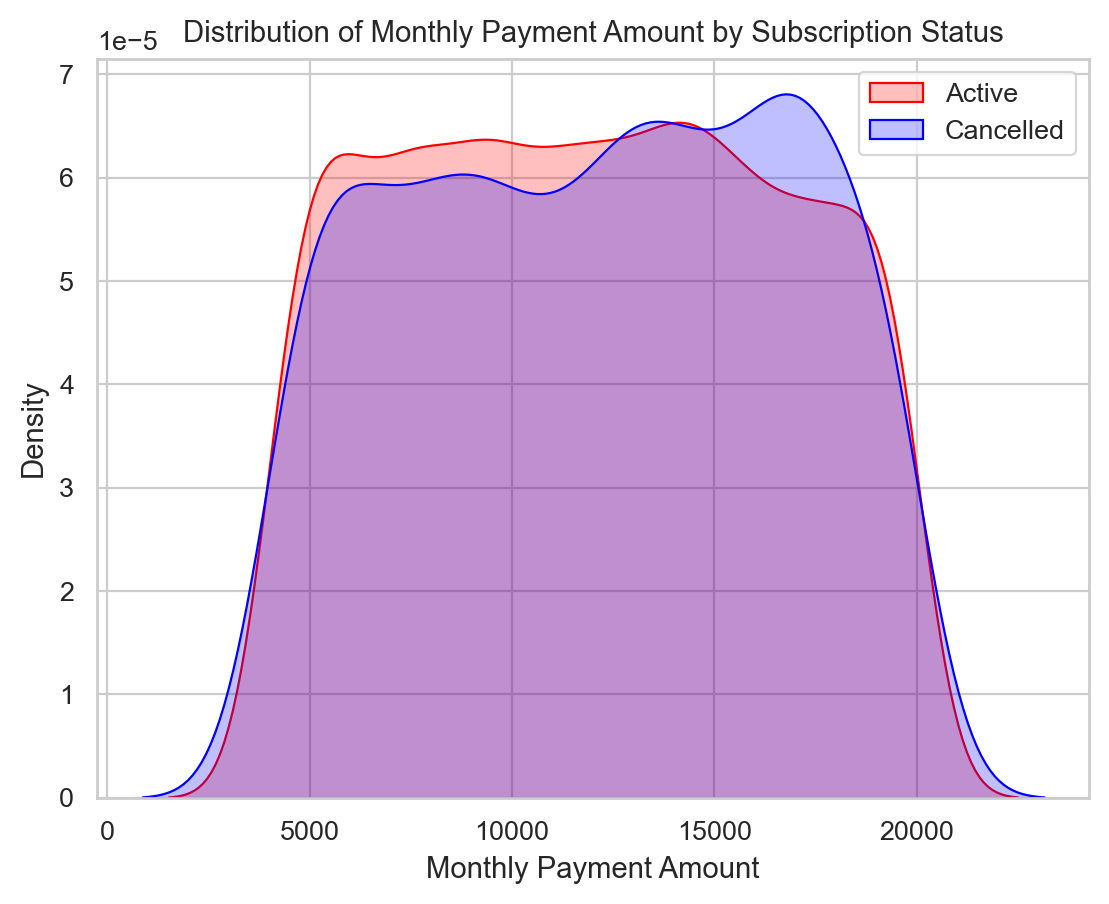

In [122]:
plot_nv(data, 'monthly_payment_amount')



sns.set_context("paper",font_scale=1.1)
ax = sns.kdeplot(data.monthly_payment_amount[(data["subscription_status"] == 'Active') ],
                color="Red", shade = True);
ax = sns.kdeplot(data.monthly_payment_amount[(data["subscription_status"] == 'Cancelled') ],
                ax =ax, color="Blue", shade= True);
ax.legend(["Active","Cancelled"],loc='upper right');
ax.set_ylabel('Density');
ax.set_xlabel('Monthly Payment Amount');
ax.set_title('Distribution of Monthly Payment Amount by Subscription Status');



Customers with higher monthly payments are more likely to cancel their subscription.

C:\Users\DELL\AppData\Local\Temp\ipykernel_15312\3175758177.py:22: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(x=feature, y='subscription_status', data=df_func, palette=colors, ax=ax2)
C:\Users\DELL\AppData\Local\Temp\ipykernel_15312\3175758177.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['Active', 'Cancelled'])


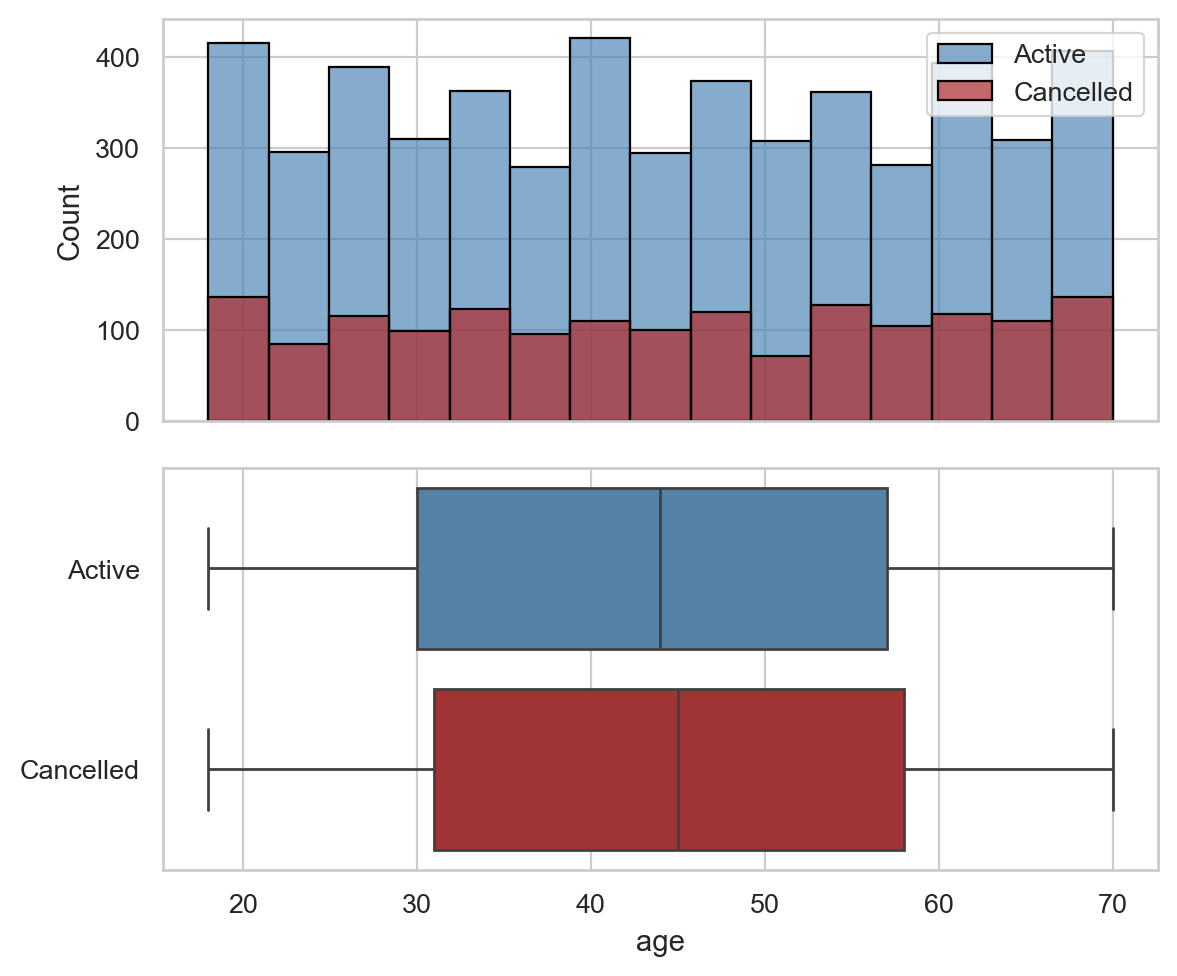

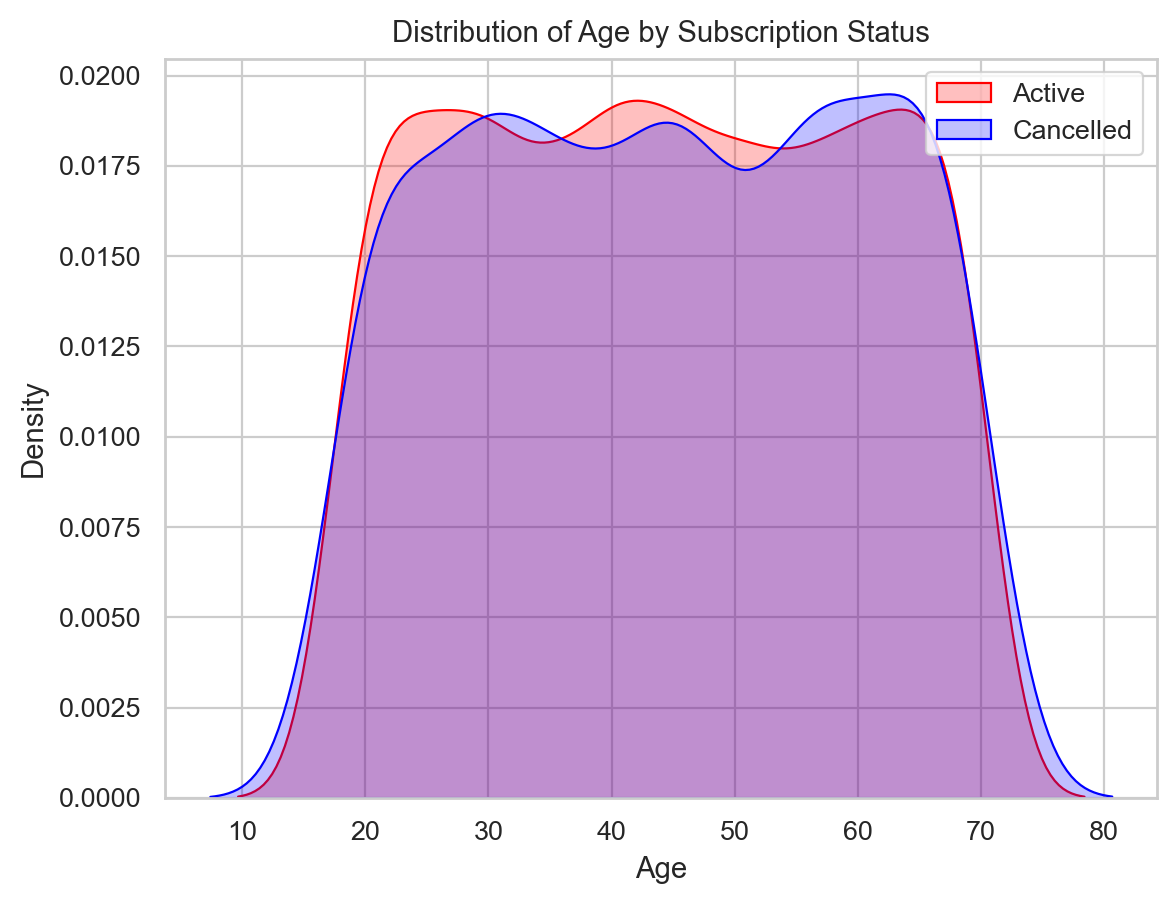

In [123]:
plot_nv(data, 'age')


sns.set_context("paper",font_scale=1.1)
ax = sns.kdeplot(data.age[(data["subscription_status"] == 'Active') ],
                color="Red", shade = True);
ax = sns.kdeplot(data.age[(data["subscription_status"] == 'Cancelled') ],
                ax =ax, color="Blue", shade= True);
ax.legend(["Active","Cancelled"],loc='upper right');
ax.set_ylabel('Density');
ax.set_xlabel('Age');
ax.set_title('Distribution of Age by Subscription Status');


Older customers are more likely to cancel their subscription.

C:\Users\DELL\AppData\Local\Temp\ipykernel_15312\3175758177.py:22: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(x=feature, y='subscription_status', data=df_func, palette=colors, ax=ax2)
C:\Users\DELL\AppData\Local\Temp\ipykernel_15312\3175758177.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['Active', 'Cancelled'])


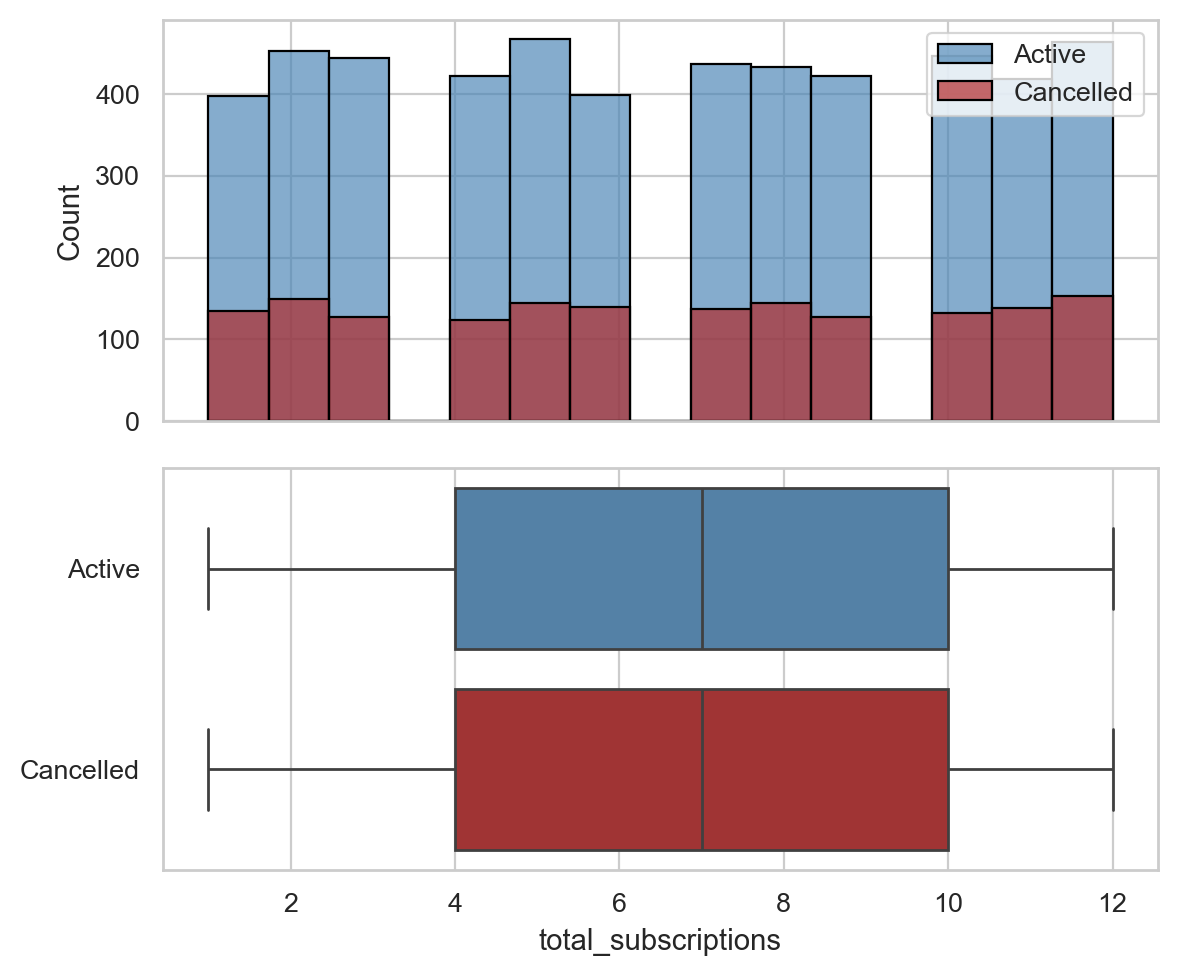

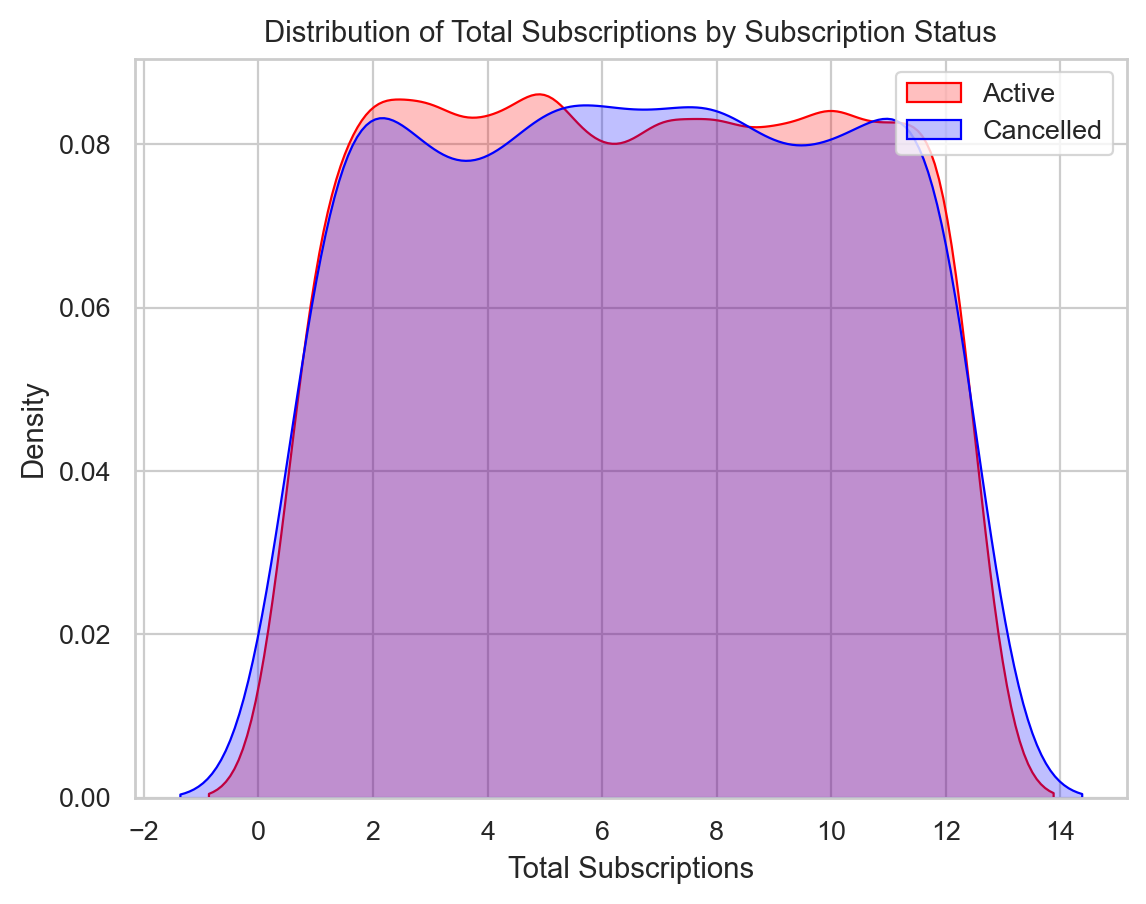

In [124]:
plot_nv(data, 'total_subscriptions')


sns.set_context("paper",font_scale=1.1)
ax = sns.kdeplot(data.total_subscriptions[(data["subscription_status"] == 'Active') ],
                color="Red", shade = True);
ax = sns.kdeplot(data.total_subscriptions[(data["subscription_status"] == 'Cancelled') ],
                ax =ax, color="Blue", shade= True);
ax.legend(["Active","Cancelled"],loc='upper right');
ax.set_ylabel('Density');
ax.set_xlabel('Total Subscriptions');
ax.set_title('Distribution of Total Subscriptions by Subscription Status');


Check for relationship between the variables

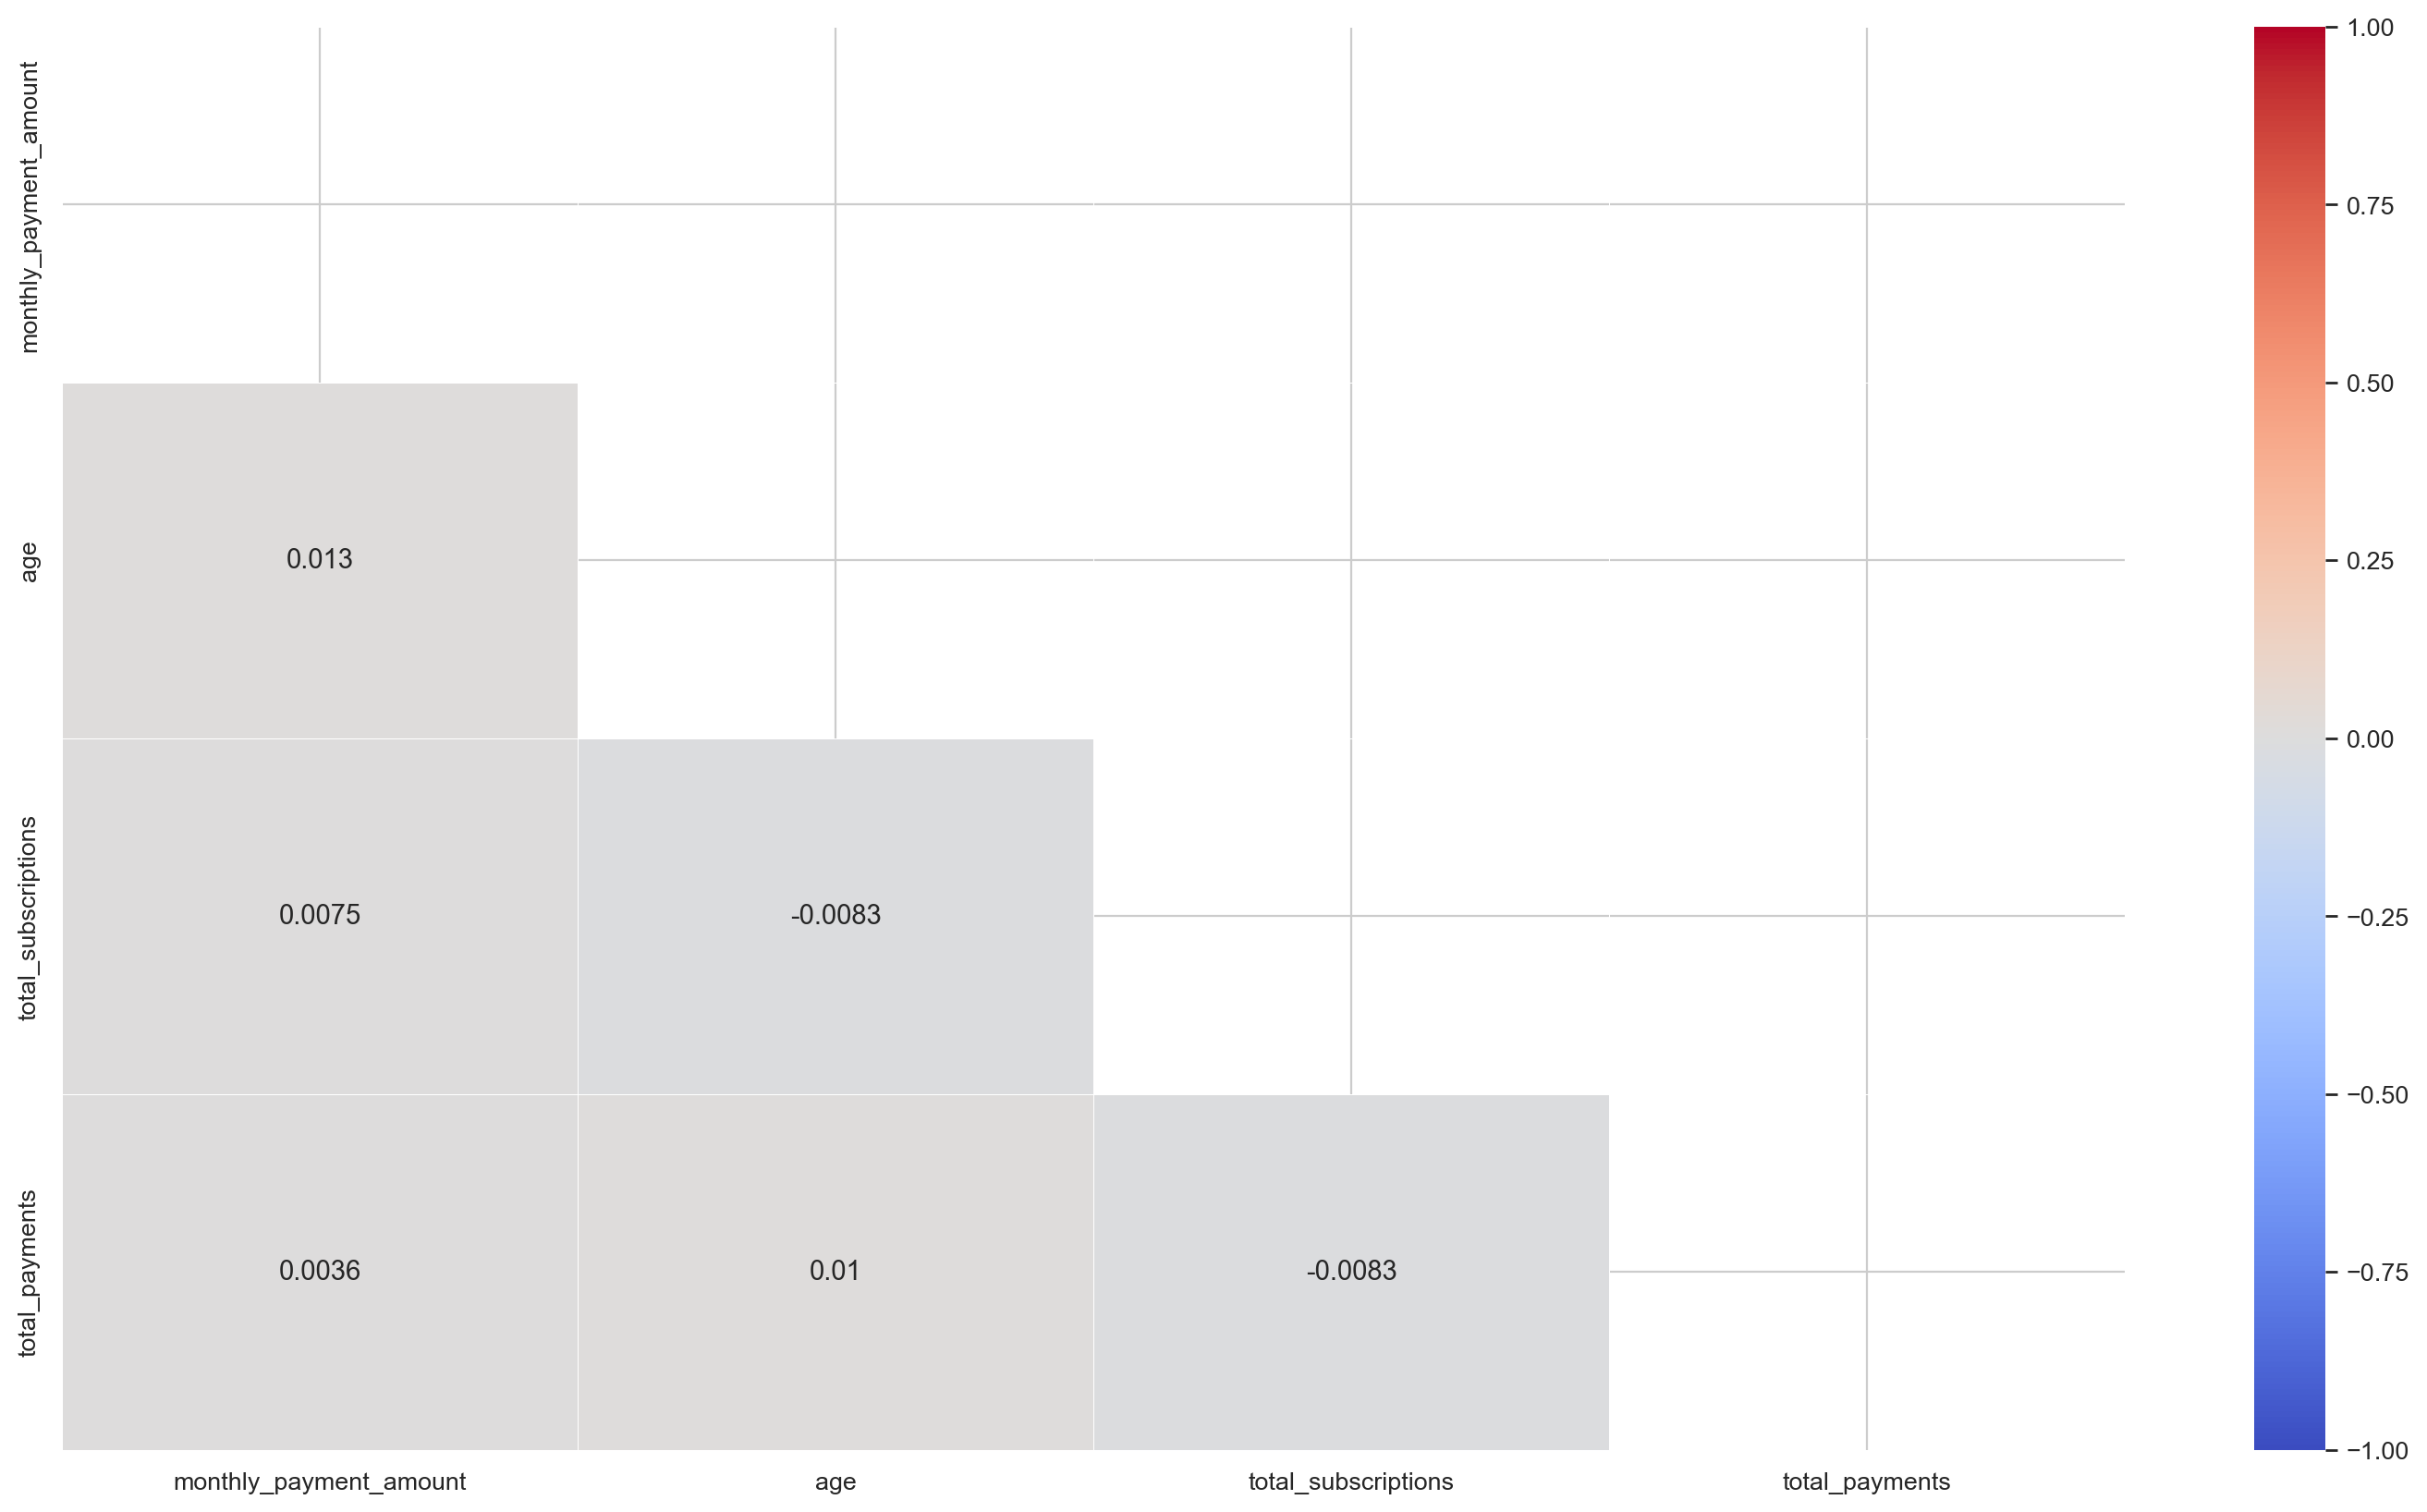

In [125]:
cols = ['monthly_payment_amount','age','total_subscriptions','total_payments']


plt.figure(figsize=(18, 10))

corr = data[cols].apply(lambda x: pd.factorize(x)[0]).corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)



In [126]:
data2 = data.copy()

data2['subscription_status'] = LabelEncoder().fit_transform(data2['subscription_status'])

#Get the correlation coefficient and p-value
corr_df = pd.DataFrame(columns= ['correlation_coef', 'p-value'])


for col in data[cols]:
    if pd.api.types.is_numeric_dtype(data2[col]) and col != 'subscription_status':
        r, p = stats.pearsonr(data2['subscription_status'], data2[col])
        corr_df.loc[col] = [round(r, 3), round(p, 6)]

corr_df



,correlation_coef,p-value
monthly_payment_amount,0.018,0.126155
age,0.011,0.349899
total_subscriptions,0.002,0.887817
total_payments,-0.002,0.859680



The correclation coefficient is the the estimated effect of an independent variable on the dependent variable. While the p-value indictates the significance.

Null Hypothesis (Ho): There is no statistically significant relationship between the independent and dependent variable

Alternative Hypothesis (H1): There is a statistically significant relationship between the independent and dependent variable

For p-value equals to or less than 0.05, we do not accept the Null Hypothesis. Hence we conclude that there is a statistically significant relationship between the independent and dependent variable. I.e The indepedent variables have significant effect on the dependent variable.

The p-value for monthly_payment_amount, age, total_subscriptions and total_payments is greater than 0.05 hence we will accept the Null Hypothesis (Ho): There is no statistically significant relationship between the independent variables and the target variable (subscription_status).

We can decide to drop the variables with no statistically significant relationship, and build the model using the ones a statistically significant relationship. However, we don't have to because the sklearn class that will be used to build the model will identify the best features.


### Data Preprocessing

In [200]:

# Feature enginering
data_tf = data.copy()
data_tf['last_order_date'] =  pd.to_datetime(data_tf['last_order_date'])
data_tf['subscription_start_date'] =  pd.to_datetime(data_tf['subscription_start_date'])



current_date = dt.datetime(2024, 1, 1)

data_tf['recency'] = (current_date - data_tf['last_order_date']).dt.days
data_tf['tenure'] = (current_date - data_tf['subscription_start_date']).dt.days




# Encoding the categorical string variables
def map_columns(data, column_mappings):
    '''Map specified columns in the DataFrame using the provided mappings.'''
    data_mapped = data.copy()
    
    for column, mapping in column_mappings.items():
        data_mapped[column] = data_mapped[column].map(mapping)
    
    return data_mapped

column_mappings = {
    'payment_method': {'Mobile Money': 1, 'Bank Transfer': 2, 'Debit Card': 3, 'Credit Card': 4},
    'gender': {'Male': 1, 'Female': 2},
    'employment_status': {'Employed': 1, 'Unemployed': 2, 'Student': 3},
    'subscription_status': {'Cancelled': 0, 'Active': 1}

}

data_tf_encoded = map_columns(data_tf, column_mappings)
data_tf_encoded.head(2)

,customer_id,subscription_start_date,subscription_end_date,subscription_status,cancellation_reason,monthly_payment_amount,total_payments,last_order_date,age,gender,employment_status,total_subscriptions,payment_method,recency,tenure
0,61d8161d-fd47-484c-8b14-0c31f40031a7,2023-02-14,12/31/2023,1,Other,15728.34560,1,2023-04-20,31,2,1,9,1,256,321
1,6ef4b93b-0ff0-40fd-9ddc-38c3465b27ba,2023-01-29,12/31/2023,0,Changed service,16729.15228,9,2023-11-03,70,2,2,7,3,59,337


In [201]:
data_tf_encoded.isnull().sum()

customer_id                0
subscription_start_date    0
subscription_end_date      0
subscription_status        0
cancellation_reason        0
monthly_payment_amount     0
total_payments             0
last_order_date            0
age                        0
gender                     0
employment_status          0
total_subscriptions        0
payment_method             0
recency                    0
tenure                     0
dtype: int64

### Training a Model

In [202]:
tv = ['monthly_payment_amount','total_payments','age', 'gender','total_subscriptions','payment_method','employment_status','recency','tenure']    

X = data_tf_encoded[tv].values
y = data_tf_encoded['subscription_status'].values



#### Spliting the data into test and training set

In [229]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#### Training and Evaluation

Model: Logistic Regression
Accuracy: 0.509929906542056
Precision: 0.7436743674367436
Recall: 0.5273010920436817
F1-score: 0.6170698311273392

Confusion Matrix:


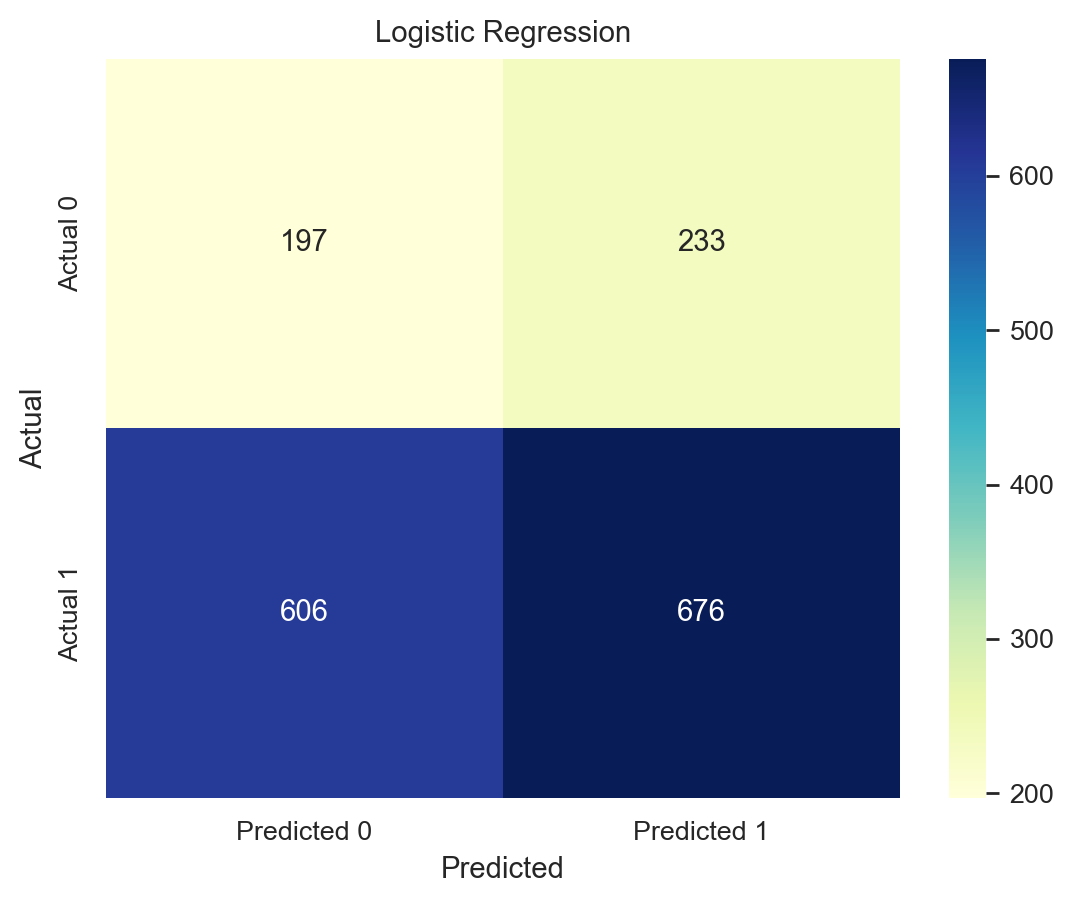



Model: Random Forest
Accuracy: 0.7488317757009346
Precision: 0.7488317757009346
Recall: 1.0
F1-score: 0.8563794255177021

Confusion Matrix:


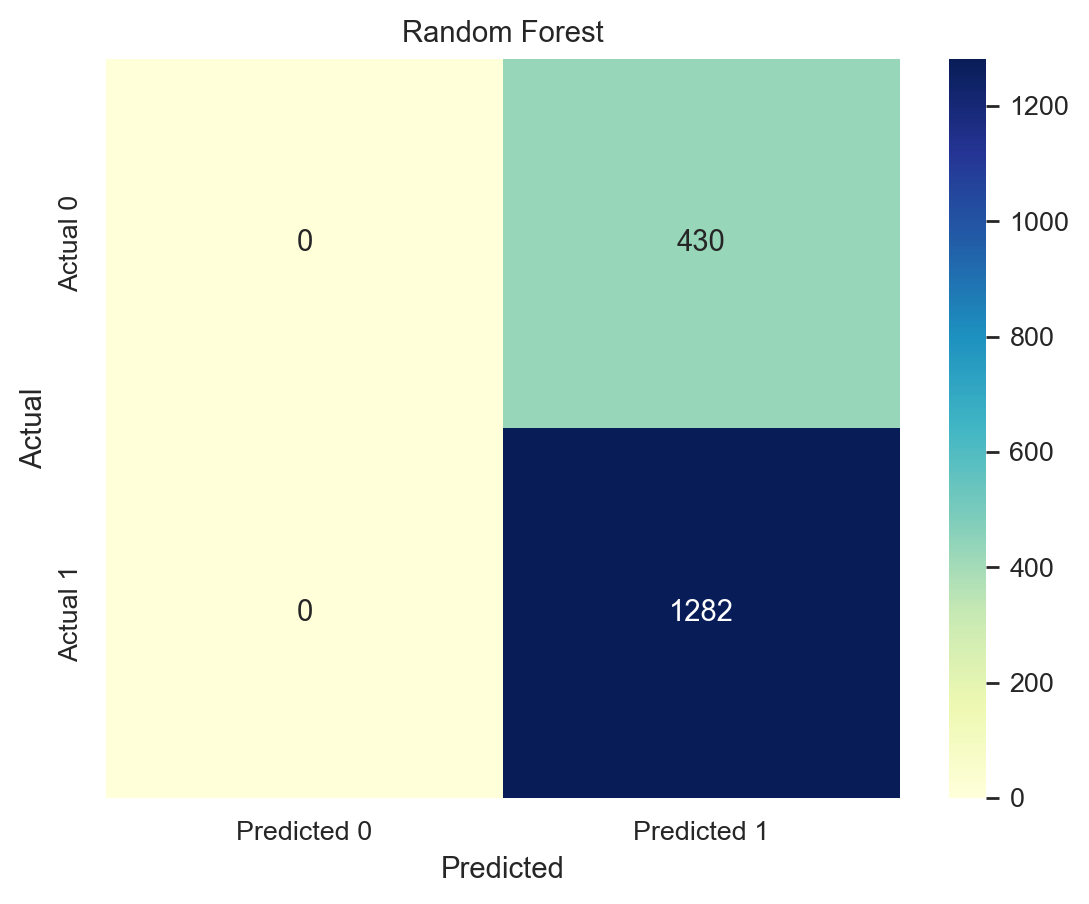



Model: SVM
Accuracy: 0.7488317757009346
Precision: 0.7488317757009346
Recall: 1.0
F1-score: 0.8563794255177021

Confusion Matrix:


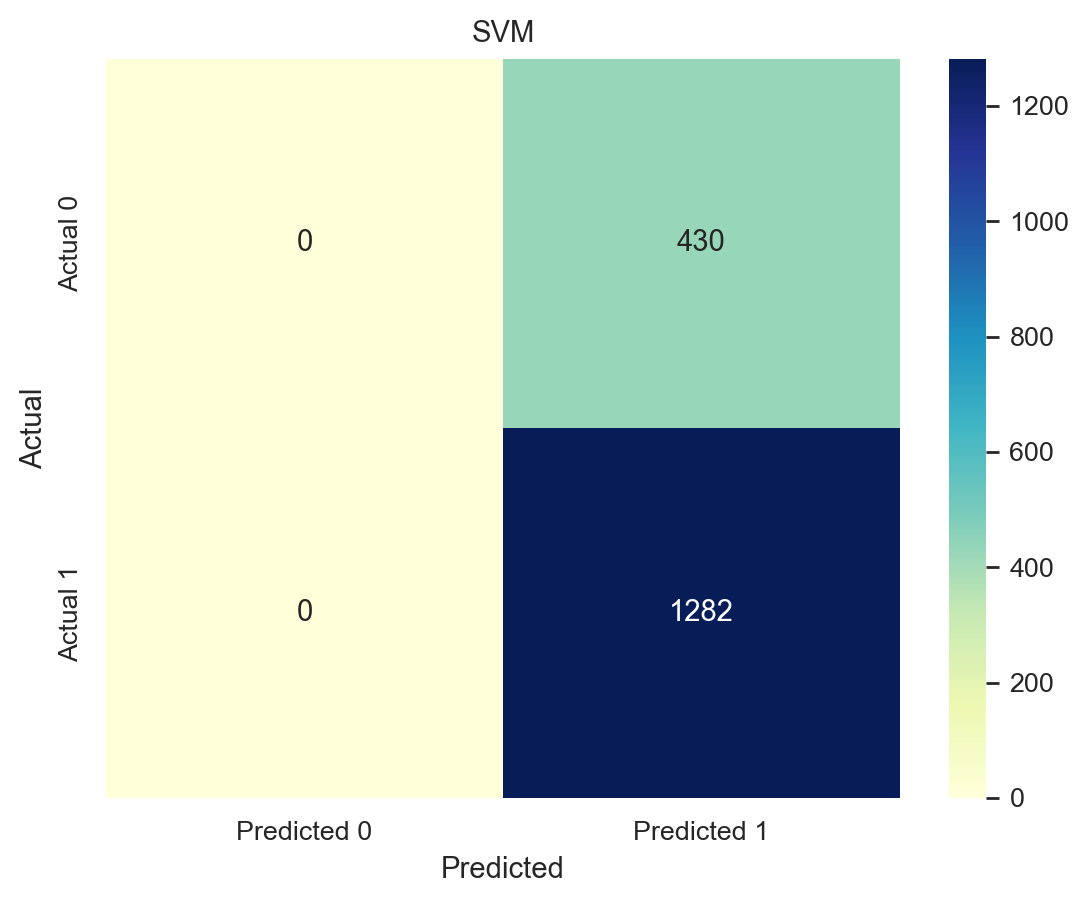

In [237]:


scaler =  StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
# Note, the fit method is not applied on the test set
X_test_scaled  = scaler.transform(X_test)

# Define the models
models = [
    ('Logistic Regression', LogisticRegression()),
    ('Random Forest', RandomForestClassifier()),
    ('SVM', SVC()),
]
results = []
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test_scaled)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    conf_matrix = confusion_matrix(y_test, y_pred)
    results.append((name, accuracy, precision, recall, f1, conf_matrix))

# Display the results, confusion matrices, and additional statistics
for name, accuracy, precision, recall, f1, conf_matrix in results:
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1}\n")

    print("Confusion Matrix:")
    df_confusion = pd.DataFrame(conf_matrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
    sns.heatmap(df_confusion, annot=True, fmt='d', cmap="YlGnBu")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{name}')
    plt.show()
    print('\n')

Either the Random Forest Model or Support Vector Model would be sufficient as they both have a very high recall (100%),  indicating that the model effectively captures almost all of the actual positive instances. However the models can be improved upon as they have a fairly good Accuray and Precision rate.

### Predicting customers that will likely cancel their subscription

In [211]:
ncd = pd.read_csv('C:\\Users\\DELL\\Downloads\\new_customer_data.csv') 

In [223]:
# Feature enginering
data_tf_ncd = ncd.copy()
data_tf_ncd['last_order_date'] =  pd.to_datetime(data_tf_ncd['last_order_date'])
data_tf_ncd['subscription_start_date'] =  pd.to_datetime(data_tf_ncd['subscription_start_date'])



current_date = dt.datetime(2024, 1, 1)

data_tf_ncd['recency'] = (current_date - data_tf_ncd['last_order_date']).dt.days
data_tf_ncd['tenure'] = (current_date - data_tf_ncd['subscription_start_date']).dt.days




# Encoding the categorical string variables
def map_columns(data, column_mappings):
    '''Map specified columns in the DataFrame using the provided mappings.'''
    data_mapped = data.copy()
    
    for column, mapping in column_mappings.items():
        data_mapped[column] = data_mapped[column].map(mapping)
    
    return data_mapped

column_mappings = {
    'payment_method': {'Mobile Money': 1, 'Bank Transfer': 2, 'Debit Card': 3, 'Credit Card': 4},
    'gender': {'Male': 1, 'Female': 2},
    'employment_status': {'Employed': 1, 'Unemployed': 2, 'Student': 3},
  

}

data_tf_encoded_ncd = map_columns(data_tf_ncd, column_mappings)
data_tf_encoded_ncd.head(2)

,customer_id,subscription_start_date,subscription_end_date,monthly_payment_amount,total_payments,last_order_date,age,gender,employment_status,total_subscriptions,payment_method,recency,tenure
0,abbcc325-2272-49aa-9e69-70926fc04e97,2022-12-11,12/31/2023,17542.042950,7,2023-08-08,62,1,2,1,3,146,386
1,a0b136ba-8f17-4b16-a14a-7dfeb6677783,2023-03-28,12/31/2023,4736.015173,5,2023-11-30,48,1,3,8,1,32,279


#### Using Logistic Regression Model to make predictions

In [ ]:

rfc_model = RandomForestClassifier().fit(X_train, y_train)

In [275]:


ncd_data = data_tf_encoded_ncd[['monthly_payment_amount','total_payments','age', 'gender','total_subscriptions','payment_method','employment_status','recency','tenure']]

scaler =  StandardScaler()

ncd_data_scaled  = scaler.fit_transform(ncd_data)
y_pred_ncd = rfc_model.predict(ncd_data_scaled)


data_tf_encoded_ncd['predicted_subscription_status'] = y_pred_ncd


data_tf_encoded_ncd[data_tf_encoded_ncd['predicted_subscription_status']== 1].head()


,customer_id,subscription_start_date,subscription_end_date,monthly_payment_amount,total_payments,last_order_date,age,gender,employment_status,total_subscriptions,payment_method,recency,tenure,predicted_subscription_status
17,77889735-7de3-4662-867e-4c7ea62f534a,2023-10-06,3/12/2024,19805.16708,12,2023-12-26,20,1,2,12,1,6,87,1
34,eb3b1e8f-f5d6-40cd-94c9-a80721a8cc1b,2023-05-27,1/16/2024,11112.53602,12,2023-07-01,43,1,2,8,4,184,219,1
39,53f41791-0112-4a3c-92f9-bc5214920fbf,2023-01-03,12/31/2023,19088.10730,12,2023-11-04,64,1,2,9,4,58,363,1
54,f246546d-22c6-4e61-a90f-eaabb8867921,2023-04-04,12/31/2023,12884.18963,12,2023-11-09,23,2,3,4,2,53,272,1
79,bd239d3d-b841-4e6f-9acc-8527849c22fc,2023-08-24,4/21/2024,12002.37832,12,2023-09-30,69,2,3,3,3,93,130,1


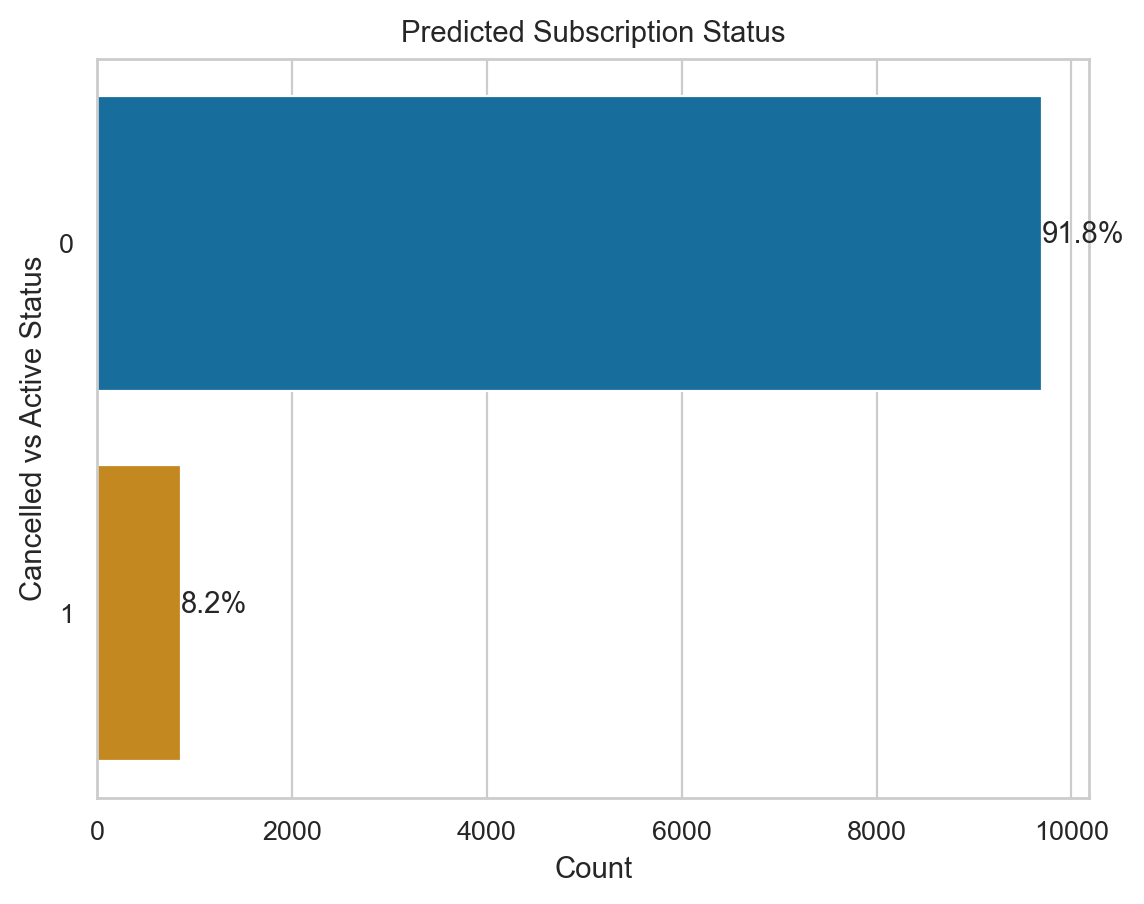

Out of 10559 customers 862 are predicted to canel their subscription.


In [276]:
sns.set_style('whitegrid')

# Create the countplot and naming it 'plot'. 
plot = sns.countplot(y='predicted_subscription_status', data=data_tf_encoded_ncd, palette='colorblind')

plt.xlabel('Count')
plt.ylabel('Cancelled vs Active Status')
plt.title('Predicted Subscription Status')

total = len(data_tf_encoded_ncd['predicted_subscription_status']) 

for p in plot.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height() / 2
    plot.annotate(percentage, (x, y))
plt.show()




cancel = len(data_tf_encoded_ncd[data_tf_encoded_ncd['predicted_subscription_status']== 1] )
total = len(data_tf_encoded_ncd)

print(f'Out of {total} customers {cancel} are predicted to canel their subscription.')

### Findings and Conclusion


- Overall Churn Rate:
A significant 24.1% of customers canceled their subscriptions, indicating a notable churn rate. This emphasizes the urgency of delving into specific details to understand the underlying reasons for such a substantial proportion of cancellations.

- Reasons for Cancellations:
The majority of cancellations were attributed to customer dissatisfaction (32.6%) with the service and a desire for a different service provider (35.4%). This insight underscores the importance of evaluating and improving the quality of service to align with customer expectations and to understand market dynamics in comparison to competitors.

- Gender Disparity:
The churn rate for female customers is slightly higher than that of male customers, suggesting potential gender-specific factors influencing subscription cancellations. Further investigation is warranted to identify and address these gender-related considerations.

- Employment Status Impact: 
Employed customers exhibit a higher churn rate compared to unemployed customers and students. This finding underscores the importance of tailoring retention strategies to address the distinct needs and expectations of customers based on their employment status.

- Monthly Payment Influence:
Customers with higher monthly payments are more likely to cancel their subscriptions. This observation highlights the significance of pricing strategies and the perceived value customers receive in relation to their subscription costs.

- Age as a Factor:
Older customers are more likely to cancel their subscriptions, indicating potential variations in preferences or expectations based on age demographics. Understanding the distinct needs of different age groups can inform targeted retention initiatives.

- Statistical Significance:
The p-values for monthly_payment_amount, age, total_subscriptions, and total_payments are greater than 0.05. This leads to accepting the Null Hypothesis, suggesting that there is no statistically significant relationship between these independent variables and the target variable (subscription_status). This underscores the importance of considering additional factors or refining the model for improved predictive accuracy.

- Conclusion:
In conclusion, the beverage subscription service churn rate analysis reveals crucial insights into the dynamics influencing customer cancellations. The high overall churn rate emphasizes the need for a strategic and data-driven approach to customer retention. Addressing customer dissatisfaction and understanding the desire for alternative service providers are pivotal in enhancing service quality.

The identified gender disparity, employment status impact, monthly payment influence, and age-related patterns offer valuable considerations for tailoring retention strategies. Strategic interventions, personalized communication, and service improvements can be implemented to address the specific needs of diverse customer segments.

The Random Forest Classifier Model's prediction of an 8.2% churn rate for new customers provides an actionable metric for proactively managing and mitigating future cancellations. By leveraging these findings, the beverage subscription service can refine its strategies, foster customer loyalty, and position itself competitively in the dynamic market landscape.